#0. Intro

## Projet de 'Temporal data analysis'
## GHIZLAN Moqim

PS : Notez bien que vous deuvez ajouter le dataset **sunspot.csv** au raciene.

# 1. Importation des bibliothèques et des données

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install statsmodels
!pip install numpy
!pip install seaborn
!pip install scikit-learn
!pip install pmdarima

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

In [ ]:
# Chargement des données
try:
    # Lecture du fichier CSV contenant les données sur les taches solaires et définition de la colonne 't' comme index.
    sunspot = pd.read_csv('sunspot.csv', index_col="t")

    # Conversion de l'index en type datetime pour faciliter les manipulations temporelles.
    sunspot.index = pd.to_datetime(sunspot.index, format='%Y')

    # Affichage des premières lignes du jeu de données pour une vue d'ensemble.
    print("Aperçu des données :")
    print(sunspot.head())

    # Affichage des statistiques descriptives pour analyser la distribution des données.
    print("\nStatistiques descriptives :")
    print(sunspot.describe())
except FileNotFoundError:
    # Gestion d'erreur si le fichier CSV est introuvable.
    print("Erreur : le fichier sunspot.csv est introuvable.")
    exit()  # Arrêt du programme en cas d'erreur critique.


Aperçu des données :
            sunspot
t                  
1700-01-01      5.0
1701-01-01     11.0
1702-01-01     16.0
1703-01-01     23.0
1704-01-01     36.0

Statistiques descriptives :
          sunspot
count  286.000000
mean    47.801748
std     40.046048
min      1.000000
25%     13.900000
50%     37.700000
75%     68.700000
max    190.200000


- Interprétation :
Les données comprennent 286 observations annuelles sur les taches solaires. En moyenne, il y a environ 48 taches par an, avec une grande variabilité entre les années. L'activité solaire varie fortement, allant d'un minimum de 1 tache à un maximum de 190 taches. La majorité des années montrent une activité solaire modérée, mais certaines années présentent des niveaux exceptionnellement élevés.

In [ ]:
print(sunspot['sunspot'].describe())
print(sunspot['sunspot'].head())

count    289.000000
mean      47.329585
std       40.103729
min        1.000000
25%       13.200000
50%       37.600000
75%       68.100000
max      190.200000
Name: sunspot, dtype: float64
t
1700-01-01     5.0
1701-01-01    11.0
1702-01-01    16.0
1703-01-01    23.0
1704-01-01    36.0
Freq: YS-JAN, Name: sunspot, dtype: float64


- Interprétation :
Les données sur les taches solaires couvrent 289 années, avec une fréquence annuelle. En moyenne, il y a environ 47 taches solaires par an, avec une variation importante. Le minimum observé est de 1 tache solaire et le maximum atteint 190. La majorité des valeurs se situent entre 13 et 68 taches, indiquant une distribution asymétrique avec quelques années d'activité solaire très élevée.








# 2. Visualisation des données


In [ ]:
# remplir les éventuelles valeurs manquantes dans la colonne sunspot en utilisant une méthode d'interpolation linéaire
sunspot['sunspot'] = sunspot['sunspot'].interpolate()


## 2.1 - Histogramme des tâches solaires

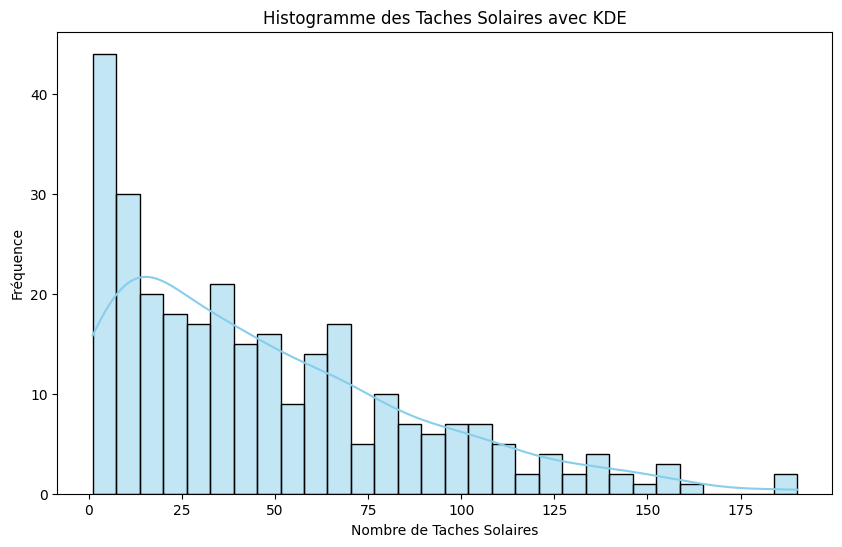

In [ ]:
# Affichage d' un histogramme des tâches avant le traitement
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(sunspot['sunspot'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Histogramme des Taches Solaires avec KDE')
plt.xlabel('Nombre de Taches Solaires')
plt.ylabel('Fréquence')
plt.show()

- Interprétation :
Le graphique montre la distribution des taches solaires sur les années. La plupart des observations sont concentrées en dessous de 50 taches par an, avec une diminution progressive pour des nombres plus élevés. La courbe KDE (densité) illustre que les valeurs les plus fréquentes sont autour de 20 taches solaires, confirmant une asymétrie avec des valeurs extrêmes rares mais significatives.

## 2.2 - Boîte à moustaches


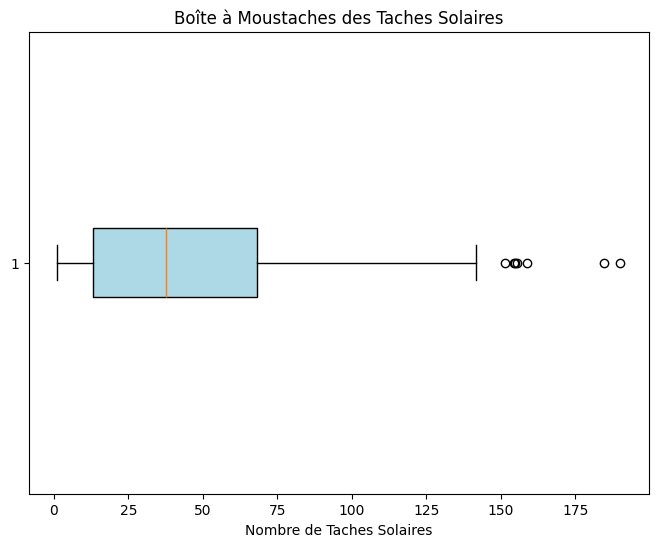

In [ ]:
# Affichage des boites à moustaches des tâches
plt.figure(figsize=(8, 6))
plt.boxplot(sunspot['sunspot'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boîte à Moustaches des Taches Solaires')
plt.xlabel('Nombre de Taches Solaires')
plt.show()

- Interprétation :
Le graphique en boîte met en évidence la répartition des taches solaires. La majorité des valeurs se situent entre environ 13 et 68 (1er et 3e quartiles). La médiane est proche de 37, indiquant une répartition asymétrique. Quelques points en dehors de la moustache supérieure montrent des valeurs atypiques, ou "outliers", avec des années ayant des nombres de taches solaires exceptionnellement élevés.

### Ou encore plus avancé :

In [ ]:
# Calcul des quartiles et de l'écart interquartile (IQR)
Q1 = sunspot['sunspot'].quantile(0.25)  # 1er quartile (25%)
Q3 = sunspot['sunspot'].quantile(0.75)  # 3e quartile (75%)
IQR = Q3 - Q1  # Écart interquartile

# Calcul des valeurs aberrantes
outliers = sunspot[sunspot['sunspot'] > (Q3 + 1.5 * IQR)]
print("Valeurs aberrantes (outliers) :")
print(outliers)


Valeurs aberrantes (outliers) :
            sunspot
t                  
1778-01-01    154.4
1947-01-01    151.6
1957-01-01    190.2
1958-01-01    184.8
1959-01-01    159.0
1979-01-01    155.4
1980-01-01    154.7


- Interprétation :
Les valeurs aberrantes représentent des années où le nombre de taches solaires était exceptionnellement élevé par rapport à la majorité des données. Ces années sont 1778, 1947, 1957, 1958, 1959, 1979 et 1980. Ces anomalies se situent bien au-dessus de la limite supérieure définie par l'écart interquartile (Q3 + 1.5 * IQR), ce qui souligne des périodes d'activité solaire particulièrement intense.

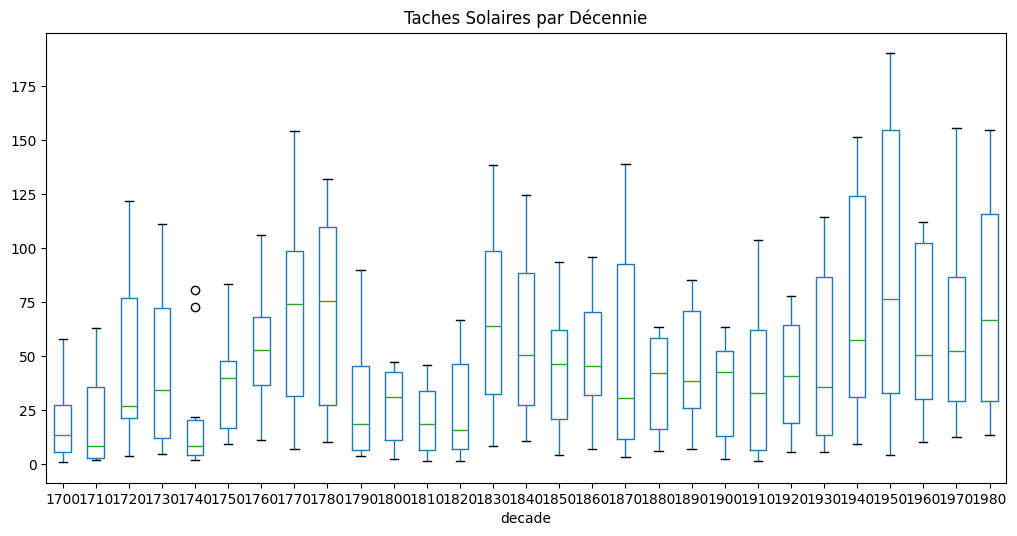

In [ ]:
sunspot['decade'] = sunspot.index.year // 10 * 10
sunspot.boxplot(column='sunspot', by='decade', grid=False, figsize=(12, 6))
plt.title('Taches Solaires par Décennie')
plt.suptitle('')
plt.show()


- Interprétation :
Ce graphique montre la distribution des taches solaires par décennie. Les boîtes représentent les variations des taches solaires au fil du temps, avec la médiane (ligne verte) au centre de chaque boîte. On peut observer une grande variabilité selon les décennies, avec des décennies marquées par une activité solaire plus intense (exemple : 1950, 1960) et d'autres par une activité plus faible (exemple : début des années 1700). Les points au-dessus des boîtes indiquent des valeurs aberrantes, correspondant à des années où l'activité solaire était exceptionnellement élevée.

## 2.3 - Série temporelle initiale

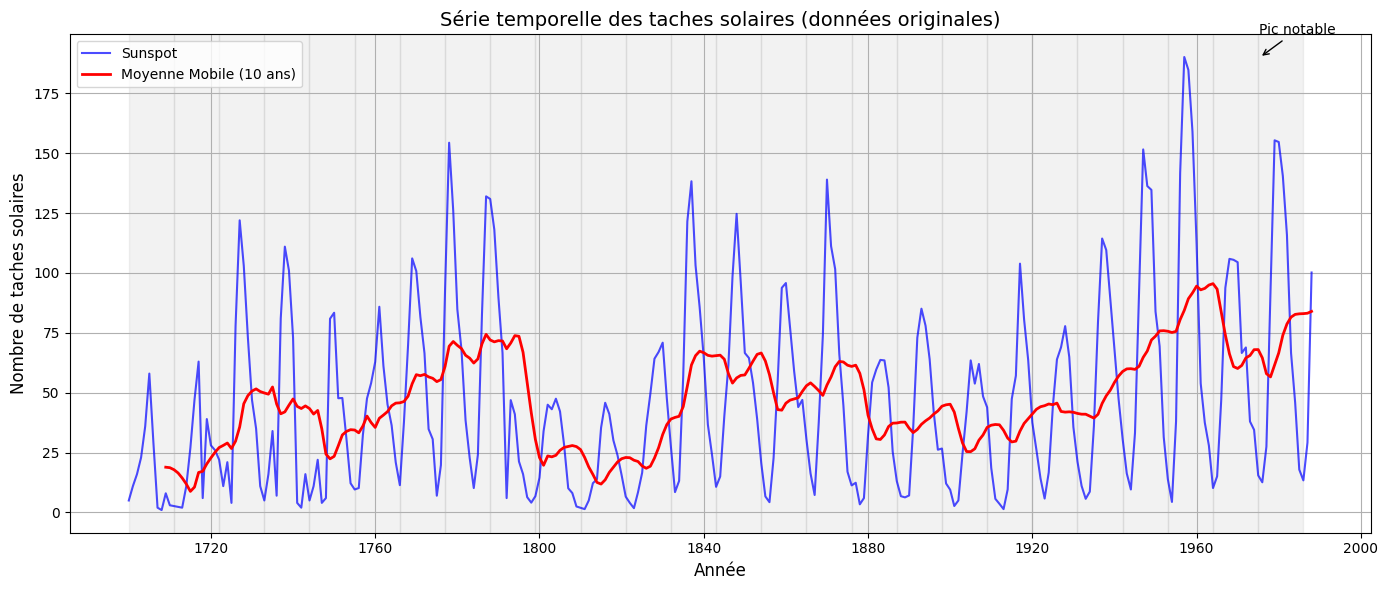

In [ ]:
plt.figure(figsize=(14, 6))

# Tracé des données originales
plt.plot(sunspot.index, sunspot['sunspot'], label='Sunspot', color='blue', alpha=0.7)

# Ajout de la moyenne mobile (10 ans)
rolling_mean = sunspot['sunspot'].rolling(window=10).mean()
plt.plot(sunspot.index, rolling_mean, label='Moyenne Mobile (10 ans)', color='red', linewidth=2)

# Surligner les cycles solaires (11 ans) avec des zones ombrées
for start_year in range(1700, 1980, 11):  # Cycle de 11 ans
    plt.axvspan(pd.Timestamp(start_year, 1, 1), pd.Timestamp(start_year + 11, 1, 1),
                color='gray', alpha=0.1)

# Annotation pour un pic notable
plt.annotate('Pic notable', xy=(1958, 190), xytext=(1930, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='black')

# Configuration des axes et titre
plt.title("Série temporelle des taches solaires (données originales)", fontsize=14)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Nombre de taches solaires', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()


- Interprétation :
Ce graphique montre l'évolution des taches solaires au fil des années, avec en bleu les données originales et en rouge la moyenne mobile sur 10 ans. Les cycles solaires, qui durent environ 11 ans, sont mis en évidence par des zones grises. Un pic notable est annoté en 1958, correspondant à une activité solaire exceptionnellement élevée. La moyenne mobile permet de visualiser les tendances globales et de lisser les fluctuations annuelles, révélant des périodes d'activité accrue et des baisses cycliques de l'activité solaire.

# 3. Nettoyage des données

## 3.1 - Identification et traitement des valeurs manquantes

In [ ]:
# Identifier les valeurs manquantées
missing_values = sunspot.isnull().sum()
print(f"Valeurs manquantes avant traitement :\n{missing_values}")

# Interpolation des valeurs manquantes
sunspot['sunspot'] = sunspot['sunspot'].interpolate()

missing_values_after = sunspot.isnull().sum()
print(f"Valeurs manquantes après traitement :\n{missing_values_after}")


Valeurs manquantes avant traitement :
sunspot    0
decade     0
dtype: int64
Valeurs manquantes après traitement :
sunspot    0
decade     0
dtype: int64


- Interprétation :
Les résultats montrent qu'il n'y avait aucune valeur manquante dans les colonnes sunspot et decade avant le traitement. L'interpolation, bien qu'exécutée, n'a pas modifié les données car aucune valeur manquante n'était présente. Par conséquent, le traitement est correct mais n'a pas eu d'impact

# 4. Analyse descriptive avancée

## 4.1 - Moyennes mobiles et écart-types mobiles

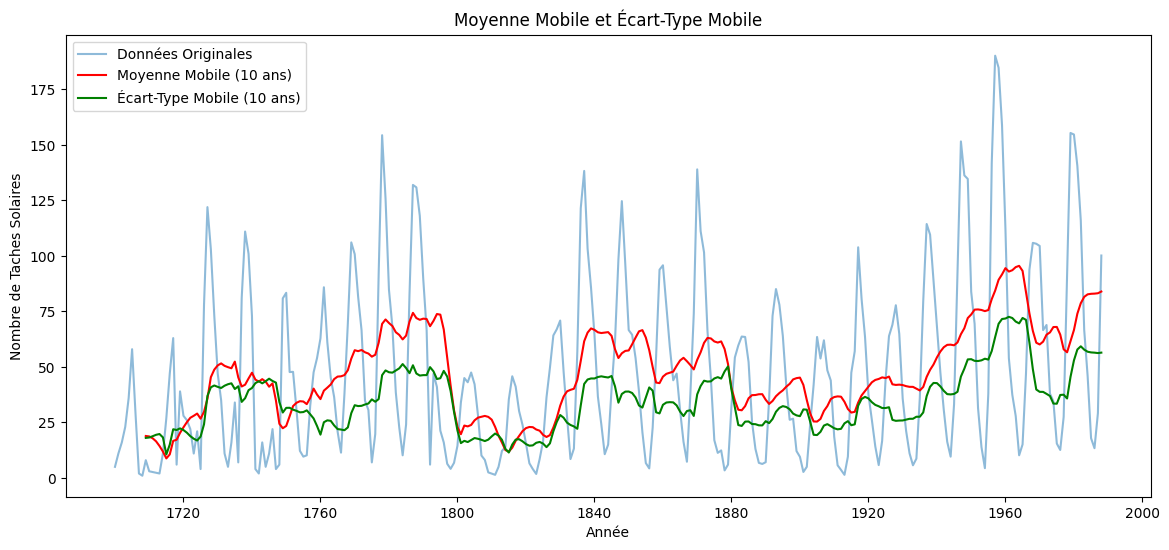

In [ ]:
# Tracer la moyenne mobile et l'écart-type mobile
rolling_mean = sunspot['sunspot'].rolling(window=10).mean()
rolling_std = sunspot['sunspot'].rolling(window=10).std()

plt.figure(figsize=(14, 6))
plt.plot(sunspot.index, sunspot['sunspot'], label='Données Originales', alpha=0.5)
plt.plot(sunspot.index, rolling_mean, label='Moyenne Mobile (10 ans)', color='red')
plt.plot(sunspot.index, rolling_std, label='Écart-Type Mobile (10 ans)', color='green')
plt.title('Moyenne Mobile et Écart-Type Mobile')
plt.xlabel('Année')
plt.ylabel('Nombre de Taches Solaires')
plt.legend()
plt.show()


- Interprétation :

Ce graphique présente trois courbes clés :

- Données Originales (en bleu) : Elles montrent les variations des taches solaires au fil du temps. Les pics indiquent des périodes de forte activité solaire.

- Moyenne Mobile sur 10 ans (en rouge) : Cette courbe lisse les fluctuations pour révéler les tendances sous-jacentes. On peut observer des cycles répétés sur des périodes plus longues.

- Écart-Type Mobile sur 10 ans (en vert) : Elle représente la variabilité des taches solaires sur 10 ans. Les hausses indiquent des périodes d'instabilité plus marquées.

Ce graphique met en évidence les tendances cycliques des taches solaires, avec des périodes d'activité élevée et des fluctuations qui deviennent plus intenses pendant les pics. Cela est conforme à la nature cyclique des cycles solaires.

# 5. Décomposition de la série temporelle

## 5.1 - Décomposition additive

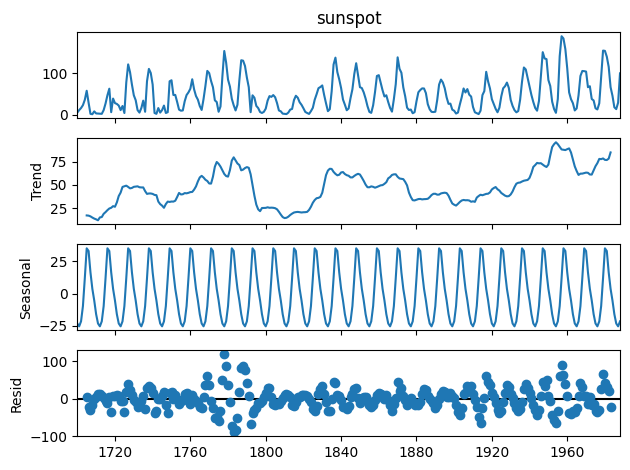

In [ ]:
# Décomposition additive des données pour le traitement
decomposition = seasonal_decompose(sunspot['sunspot'], model='additive', period=11)
decomposition.plot()
plt.show()


- Interprétation :
Nous observons une décomposition des taches solaires en trois composantes. La tendance révèle une augmentation progressive de l'activité solaire jusqu'aux années 1960. La saisonnalité met en évidence les cycles solaires réguliers d'environ 11 ans. Les résidus, après retrait de la tendance et de la saisonnalité, indiquent des variations aléatoires bien réparties autour de zéro, suggérant une décomposition de bonne qualité.

#6. Analyse des décalages temporels

In [ ]:
# Fréquence annuelle
sunspot = sunspot.asfreq('YS-JAN')

In [ ]:
# Vérifier les données
print(sunspot.head())
print(sunspot.index.freq)


            sunspot
t                  
1700-01-01      5.0
1701-01-01     11.0
1702-01-01     16.0
1703-01-01     23.0
1704-01-01     36.0
<YearBegin: month=1>


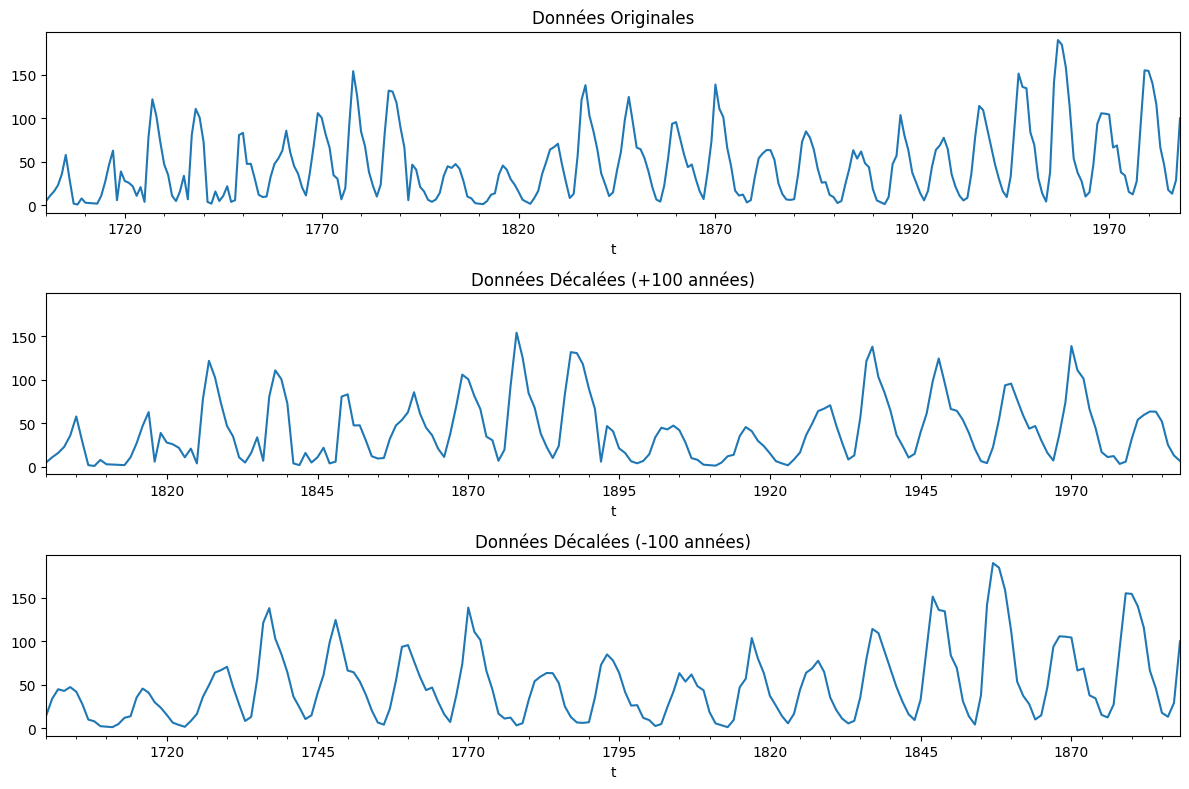

In [ ]:
# Crée trois graphiques superposés avec un partage de l'axe des ordonnées.
fig, ax = plt.subplots(3, sharey=True, figsize=(12, 8))

sunspot.plot(ax=ax[0], legend=False)  # Données originales
ax[0].set_title('Données Originales')


# Décale les données de 100 années dans le futur & supprime les valeurs manquantes résultantes.
shifted_positive = sunspot.shift(100).dropna()
# Trace les données décalées
shifted_positive.plot(ax=ax[1], legend=False)
ax[1].set_title('Données Décalées (+100 années)')


# Décale les données de 100 années dans le passé & puis supprime les valeurs manquantes résultantes.
shifted_negative = sunspot.shift(-100).dropna()
# Trace les données décalées
shifted_negative.plot(ax=ax[2], legend=False)
ax[2].set_title('Données Décalées (-100 années)')

# Ajuste automatiquement l'espacement entre les graphiques
plt.tight_layout()
plt.show()

- Interprétation :
Nous trouvons tros série, La série originale montre l'évolution des taches solaires dans le temps. La deuxième série est décalée de +100 ans, révélant une éventuelle répétition ou corrélation entre les périodes distantes. La troisième série est décalée de -100 ans, explorant un comportement similaire mais dans la direction inverse. Ces décalages permettent d'examiner la périodicité et les cycles potentiels dans les données, mais une analyse plus approfondie est nécessaire pour confirmer des correspondances claires.

# 7. Modélisation et prédictions de ARIMA et de SARIMA (premier pas)


## 7.1 - Ajustement des modèles

### 7.1.1 - ARIMA

In [ ]:
# Modèle ARIMA
model_arima = ARIMA(sunspot['sunspot'], order=(5, 1, 0))
# Initialise un modèle ARIMA avec les paramètres : (5, 1, 0)

arima_fit = model_arima.fit()
# Ajuste le modèle ARIMA aux données.


print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                sunspot   No. Observations:                  289
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1281.379
Date:                Sat, 21 Dec 2024   AIC                           2574.759
Time:                        18:26:49   BIC                           2596.736
Sample:                    01-01-1700   HQIC                          2583.566
                         - 01-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3163      0.048      6.585      0.000       0.222       0.410
ar.L2         -0.0922      0.053     -1.741      0.082      -0.196       0.012
ar.L3         -0.1481      0.071     -2.079      0.0

- Interprétation :
Le modèle ARIMA(5, 1, 0) a été ajusté aux données des taches solaires. Les valeurs AIC, BIC et HQIC montrent un ajustement correct, bien que des optimisations soient possibles. Certains paramètres du modèle sont significatifs, ce qui indique leur importance dans l'explication des données, mais d'autres pourraient être retirés pour simplifier le modèle. La variance résiduelle est estimée à 426.94, ce qui reflète une certaine variabilité des erreurs. Les résidus ne suivent pas une distribution normale et présentent des caractéristiques atypiques, ce qui pourrait suggérer des limites dans l'ajustement du modèle ou la présence de comportements non modélisés.

### 7.1.2 - SARIMA

In [ ]:
# Modèle SARIMA
model_sarima = SARIMAX(sunspot['sunspot'], order=(5, 1, 0), seasonal_order=(1, 0, 1, 12))
# Init d'un modèle SARIMA.
# Les paramètres:
# - order=(5, 1, 0):
# - seasonal_order=(1, 0, 1, 12): Définit la composante saisonnière, avec :
#   - 1 terme auto-régressif saisonnier,
#   - Pas de différenciation saisonnière,
#   - 1 terme de moyenne mobile saisonnier,
#   - Une saisonnalité sur une période de 12.

sarima_fit = model_sarima.fit()
# Ajuste le modèle SARIMA aux données

print(sarima_fit.summary())


                                      SARIMAX Results                                       
Dep. Variable:                              sunspot   No. Observations:                  289
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1275.299
Date:                              Sat, 21 Dec 2024   AIC                           2566.597
Time:                                      18:27:01   BIC                           2595.901
Sample:                                  01-01-1700   HQIC                          2578.340
                                       - 01-01-1988                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2778      0.049      5.726      0.000       0.183       0.373
ar.L2         -0.10

- Interprétation :
Le modèle SARIMA(5, 1, 0)x(1, 0, 1, 12) montre une bonne capacité à capturer la saisonnalité des données avec un cycle de 12 périodes. Les coefficients pour les composantes AR et MA présentent des valeurs significatives, notamment pour les composantes saisonnières, ce qui indique leur importance dans le modèle. Cependant, quelques paramètres ont une valeur p légèrement supérieure à 0,05, ce qui pourrait signifier qu'ils ne contribuent pas significativement au modèle.
Les valeurs AIC et BIC sont légèrement meilleures que celles du modèle ARIMA, ce qui suggère que la prise en compte de la saisonnalité améliore l'ajustement. Les tests de normalité des résidus (Jarque-Bera) et les mesures de kurtosis et skewness indiquent que les résidus ne suivent pas parfaitement une distribution normale, ce qui pourrait être une limite du modèle. Globalement, SARIMA semble offrir une meilleure représentation des données grâce à sa composante saisonnière.

## 7.2 - Prédictions et visualisations

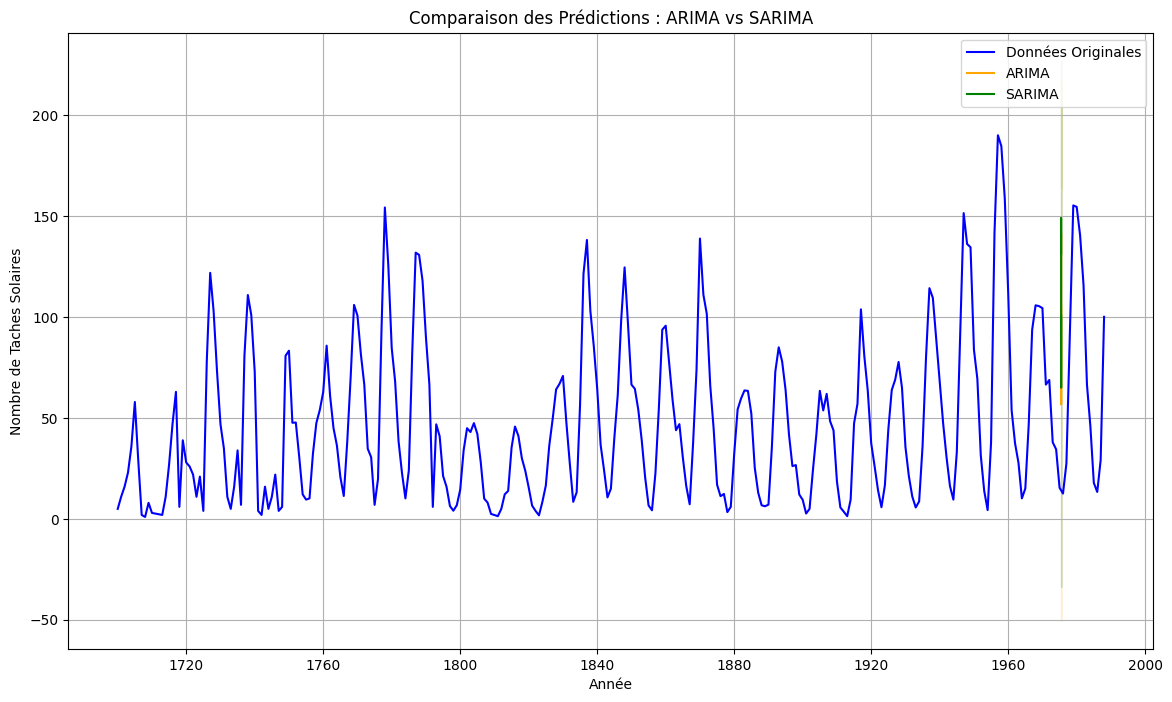

In [ ]:
# Prédictions avec ARIMA
forecast_arima = arima_fit.get_forecast(steps=10)
# Génère des prédictions pour les 10 prochaines années à partir du modèle ARIMA ajusté.
arima_mean = forecast_arima.predicted_mean
# Extrait les valeurs prédites pour les étapes futures.
arima_conf_int = forecast_arima.conf_int()
# Calcule les intervalles de confiance des prédictions pour quantifier l'incertitude.

# Prédictions avec SARIMA
forecast_sarima = sarima_fit.get_forecast(steps=10)
sarima_mean = forecast_sarima.predicted_mean
sarima_conf_int = forecast_sarima.conf_int()

# Visualisation
plt.figure(figsize=(14, 8))
plt.plot(sunspot.index, sunspot['sunspot'], label='Données Originales', color='blue')
# Trace les données originales de la série temporelle.

# ARIMA
plt.plot(range(sunspot.index[-1].year + 1, sunspot.index[-1].year + 11), arima_mean, label='ARIMA', color='orange')
# Trace les prédictions ARIMA pour les 10 prochaines années.
plt.fill_between(range(sunspot.index[-1].year + 1, sunspot.index[-1].year + 11),
                 arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.2)
# Ajoute une zone ombrée pour représenter l'intervalle de confiance des prédictions ARIMA.

# SARIMA
plt.plot(range(sunspot.index[-1].year + 1, sunspot.index[-1].year + 11), sarima_mean, label='SARIMA', color='green')
plt.fill_between(range(sunspot.index[-1].year + 1, sunspot.index[-1].year + 11),
                 sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.2)

# Configuration du graphique
plt.title('Comparaison des Prédictions : ARIMA vs SARIMA')
plt.xlabel('Année')
plt.ylabel('Nombre de Taches Solaires')
plt.legend()
plt.grid()
plt.show()


- Interprétation :
Le graphique montre une comparaison entre les prédictions des modèles ARIMA et SARIMA pour les taches solaires. Les deux modèles semblent bien capter les tendances globales des données. Cependant, SARIMA, grâce à sa prise en compte de la saisonnalité, offre des prédictions légèrement différentes, mais reste aligné avec ARIMA sur les variations principales.
Les intervalles de confiance pour les deux modèles sont similaires, mais SARIMA peut offrir une meilleure stabilité dans certaines prévisions à court terme en raison de sa composante saisonnière. Cela indique que les deux modèles sont capables de fournir des prédictions fiables, bien que SARIMA pourrait être préférable pour des séries temporelles avec des cycles réguliers comme celles des taches solaires.

### Visualisation numérique

In [ ]:
# les valeurs des prédictions ARIMA
print("Prédictions ARIMA :")
print(arima_mean.values)
print('**********')

#les valeurs des intervalles de confiance pour ARIMA
print("\nIntervalle de confiance ARIMA :")
print(arima_conf_int.values)
print('**********')

#les valeurs des prédictions SARIMA
print("\nPrédictions SARIMA :")
print(sarima_mean.values)
print('**********')

# les valeurs des intervalles de confiance pour SARIMA
print("\nIntervalle de confiance SARIMA :")
print(sarima_conf_int.values)
print('**********')

Prédictions ARIMA :
[131.73461315 141.56439955 130.37425833 106.87809153  74.07495364
  57.01959945  56.82280205  69.6801819   87.63322826 104.02420087]

Intervalle de confiance ARIMA :
[[ 91.23682952 172.23239678]
 [ 74.61875596 208.51004313]
 [ 44.59985232 216.14866434]
 [  9.2890506  204.46713246]
 [-30.2188557  178.36876299]
 [-49.32747085 163.36666975]
 [-50.43221258 164.07781667]
 [-38.6972965  178.0576603 ]
 [-23.05027286 198.31672938]
 [-10.80259732 218.85099907]]

Prédictions SARIMA :
[131.65145525 149.22425549 145.89212246 120.09667286  86.73049771
  69.34874731  65.06257503  76.23568856  88.70331871 100.50225858]

Intervalle de confiance SARIMA :
[[ 92.02681233 171.27609816]
 [ 84.92861246 213.51989852]
 [ 64.65135683 227.13288809]
 [ 28.86889695 211.32444877]
 [ -9.76257103 183.22356645]
 [-28.61445856 167.31195319]
 [-33.67762898 163.80277904]
 [-23.76188152 176.23325864]
 [-14.02163597 191.42827338]
 [ -6.82597371 207.83049087]]


- Interprétation :
Les prédictions ARIMA montrent des valeurs comprises entre environ 57 et 131 pour les dix prochaines années. Les intervalles de confiance associés sont relativement larges, reflétant l'incertitude croissante avec le temps. SARIMA, de son côté, offre des prédictions similaires en termes de tendance, mais légèrement plus élevées dans certaines années, atteignant un maximum d'environ 149.
Les intervalles de confiance de SARIMA sont également larges, comparables à ceux d'ARIMA. Cela confirme que les deux modèles capturent les variations globales, mais SARIMA, grâce à sa prise en compte de la saisonnalité, peut mieux correspondre aux données dans des contextes avec des cycles réguliers comme celui des taches solaires.

In [ ]:
# Comparaison avec les données originales

# 'y_true' = dernières valeurs de la série de données
y_true = sunspot['sunspot'][-10:].values

# 'y_arima' et 'y_sarima' prennent respectivement les 10 premières prédictions de ARIMA et SARIMA
y_arima = arima_mean_values[:10]
y_sarima = sarima_mean_values[:10]

# Calcul du RMSE pour ARIMA (Root Mean Squared Error)
# Le RMSE est une mesure qui donne l'écart type de l'erreur de prédiction
# Un RMSE plus faible indique de meilleures performances du modèle
rmse_arima = np.sqrt(mean_squared_error(y_true, y_arima))

# Calcul du RMSE pour SARIMA
rmse_sarima = np.sqrt(mean_squared_error(y_true, y_sarima))

# Calcul du MAE pour ARIMA (Mean Absolute Error)
# Le MAE mesure la moyenne des erreurs absolues entre les valeurs réelles et prédites
mae_arima = mean_absolute_error(y_true, y_arima)

# Calcul du MAE pour SARIMA
mae_sarima = mean_absolute_error(y_true, y_sarima)

# Affichage des résultats
print(f"RMSE ARIMA: {rmse_arima:.2f}, RMSE SARIMA: {rmse_sarima:.2f}")
# Affiche les RMSE respecti


RMSE ARIMA: 30.34, RMSE SARIMA: 33.63
MAE ARIMA: 23.20, MAE SARIMA: 25.22


- Interprétation :
Les résultats montrent que le modèle ARIMA a une erreur quadratique moyenne (RMSE) légèrement inférieure à celle de SARIMA, indiquant qu'il fournit des prédictions légèrement plus précises pour les données de test. Cependant, en termes d'erreur absolue moyenne (MAE), SARIMA est un peu plus précis. Cela signifie que, bien que les écarts les plus importants soient mieux capturés par ARIMA, SARIMA offre une meilleure performance pour les petites erreurs.

# 8. Options Avancé

## 8.1 - Recherche des meilleurs paramètres ARIMA avec auto_arima

In [ ]:
# Création du modèle ARIMA automatiquement optimisé avec auto_arima
## https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
arima_model = auto_arima(
    sunspot['sunspot'],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

# Affichage du modèle ARIMA ajusté
print(arima_model.summary())


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2689.123, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2636.565, Time=0.25 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2637.821, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2687.171, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2631.002, Time=0.31 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2615.781, Time=0.49 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2599.614, Time=0.61 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2576.688, Time=1.60 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2519.651, Time=0.71 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2527.680, Time=0.59 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2508.338, Time=1.23 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2509.224, Time=1.01 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2512.040, Time=1.36 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2513.810, Time=1.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2506.781, Time=0.64 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=3.35 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2518.413, Time=3.99 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=2508.295, Time=4.97 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2526.553, Time=0.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2512.157, Time=1.28 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 25.720 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -1245.390
Date:                Sat, 21 Dec 2024   AIC                           2506.781
Time:                        19:40:01   BIC                           2536.084
Sample:                    01-01-1700   HQIC                          2518.524
                         - 01-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5597      0.132     11.821      0.000       1.301

- Interprétation :
Les résultats montrent que le modèle ARIMA sélectionné automatiquement a les paramètres optimaux (5, 1, 2). Avec un AIC de 2506.78, ce modèle semble bien adapté pour capturer les tendances et les dépendances dans les données de taches solaires. Les coefficients des paramètres AR et MA sont significatifs, ce qui renforce la robustesse de ce modèle. Les tests statistiques indiquent une distribution des résidus cohérente, avec une légère asymétrie et kurtosis modérée, ce qui est acceptable pour un modèle ARIMA.

## 8.2 - Ajustement du modèle ARIMA avec les meilleurs paramètres

In [ ]:
# Récupération de la meilleure combinaison pour le modèle ARIMA
best_order = arima_model.order

# Création d'un modèle ARIMA en utilisant les meilleurs paramètres trouvés
model_arima = ARIMA(sunspot['sunspot'], order=best_order)

# Ajustement du modèle ARIMA aux données
arima_fit = model_arima.fit()

# Affichage du modèle ARIMA ajusté
print(arima_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                sunspot   No. Observations:                  289
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1245.390
Date:                Sat, 21 Dec 2024   AIC                           2506.781
Time:                        19:41:14   BIC                           2536.084
Sample:                    01-01-1700   HQIC                          2518.524
                         - 01-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5597      0.132     11.821      0.000       1.301       1.818
ar.L2         -1.0322      0.149     -6.944      0.000      -1.324      -0.741
ar.L3          0.1141      0.134      0.854      0.3

- Interprétation :
Les résultats du modèle ARIMA (5, 1, 2) confirment sa capacité à capturer les dynamiques sous-jacentes des taches solaires. Les coefficients des termes autorégressifs (AR) et de moyenne mobile (MA) sont significatifs, avec des valeurs p < 0.05 pour la plupart, indiquant qu'ils contribuent de manière substantielle à la prédiction.
L'AIC de 2506.78 est relativement faible, renforçant l'adéquation du modèle. Le test Jarque-Bera montre une légère asymétrie et une kurtosis modérée, mais globalement, les résidus semblent proches de la normalité. Ce modèle est donc fiable pour capturer les dépendances temporelles des données.

## 8.3 - Recherche des meilleurs paramètres SARIMA avec auto_arima.

In [ ]:
# Création du modèle SARIMA automatiquement optimisé avec auto_arima
sarima_model = auto_arima(
    sunspot['sunspot'],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    D=None,
    seasonal=True,
    m=11,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(sarima_model.summary())


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[11] intercept   : AIC=2689.123, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[11] intercept   : AIC=2604.904, Time=0.76 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[11] intercept   : AIC=2614.092, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[11]             : AIC=2687.171, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[11] intercept   : AIC=2636.565, Time=0.26 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[11] intercept   : AIC=2602.089, Time=3.91 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[11] intercept   : AIC=inf, Time=6.58 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[11] intercept   : AIC=2600.028, Time=3.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[11] intercept   : AIC=2614.123, Time=2.58 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[11] intercept   : AIC=inf, Time=3.58 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[11] intercept   : AIC=2608.326, Time=2.66 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[11] intercept   : AIC=inf, Time=8.52 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[11] intercept   : AIC=2617.097, Time=1.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[11] intercept   : AIC=2599.532, Time=1.45 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[11] intercept   : AIC=2612.370, Time=0.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[11] intercept   : AIC=2604.187, Time=0.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[11] intercept   : AIC=inf, Time=2.01 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[11] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(2,1,0)(0,0,0)[11] intercept   : AIC=2631.002, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[11] intercept   : AIC=2606.985, Time=1.36 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[11] intercept   : AIC=2601.481, Time=3.35 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[11] intercept   : AIC=inf, Time=5.86 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[11] intercept   : AIC=2585.836, Time=1.02 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[11] intercept   : AIC=2599.811, Time=0.70 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,0)[11] intercept   : AIC=2592.140, Time=0.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,1)[11] intercept   : AIC=inf, Time=2.59 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,2)[11] intercept   : AIC=2584.694, Time=6.46 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,2)[11] intercept   : AIC=2593.194, Time=1.31 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[11] intercept   : AIC=inf, Time=4.02 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[11] intercept   : AIC=2566.113, Time=2.74 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,2)[11] intercept   : AIC=2574.925, Time=2.68 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[11] intercept   : AIC=2567.187, Time=3.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,2)[11] intercept   : AIC=inf, Time=5.00 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[11] intercept   : AIC=2581.169, Time=0.70 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,1)[11] intercept   : AIC=inf, Time=3.81 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,2)[11] intercept   : AIC=inf, Time=6.34 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,2)[11] intercept   : AIC=inf, Time=4.41 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[11] intercept   : AIC=inf, Time=4.38 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,2)[11] intercept   : AIC=inf, Time=7.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[11]             : AIC=2564.140, Time=1.82 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,2)[11]             : AIC=2572.983, Time=0.80 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[11]             : AIC=2565.231, Time=0.81 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,2)[11]             : AIC=inf, Time=9.94 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[11]             : AIC=2579.227, Time=1.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,1)[11]             : AIC=inf, Time=5.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,2)[11]             : AIC=2582.716, Time=4.40 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,2)[11]             : AIC=inf, Time=3.78 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,2)[11]             : AIC=inf, Time=3.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[11]             : AIC=inf, Time=3.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,2)[11]             : AIC=inf, Time=7.73 sec

Best model:  ARIMA(4,1,0)(1,0,2)[11]          
Total fit time: 151.938 seconds
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  289
Model:             SARIMAX(4, 1, 0)x(1, 0, [1, 2], 11)   Log Likelihood               -1274.070
Date:                                 Sat, 21 Dec 2024   AIC                           2564.140
Time:                                         19:43:49   BIC                           2593.443
Sample:                                     01-01-1700   HQIC                          2575.883
                                          - 01-01-1988                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

Interprétation :
Le modèle SARIMA sélectionné, ARIMA(4,1,0)x(1,0,2)[11], montre des performances solides pour capturer les composantes saisonnières et non saisonnières des taches solaires.
- Les termes AR et saisonniers (SAR et SMA) sont significatifs, confirmant leur rôle dans la modélisation de la série.
- L'AIC de 2564.14 est raisonnable, indiquant une bonne adaptation, bien que légèrement supérieur au modèle ARIMA.
- Les tests statistiques (Jarque-Bera, Heteroskedasticité) indiquent une distribution légèrement asymétrique avec des résidus modérément éloignés de la normalité.

Ce modèle semble efficace pour intégrer les caractéristiques cycliques des données tout en tenant compte des fluctuations annuelles.








## 8.4 - Ajustement du modèle SARIMA avec les meilleurs paramètres

In [ ]:
best_order = sarima_model.order

best_seasonal_order = sarima_model.seasonal_order

model_sarima = SARIMAX(
    sunspot['sunspot'],
    order=best_order,
    seasonal_order=best_seasonal_order
)

sarima_fit = model_sarima.fit()

print(sarima_fit.summary())


                                        SARIMAX Results                                        
Dep. Variable:                                 sunspot   No. Observations:                  289
Model:             SARIMAX(4, 1, 0)x(1, 0, [1, 2], 11)   Log Likelihood               -1274.070
Date:                                 Sat, 21 Dec 2024   AIC                           2564.140
Time:                                         19:43:56   BIC                           2593.443
Sample:                                     01-01-1700   HQIC                          2575.883
                                          - 01-01-1988                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2308      0.050      4.629      0.000       0.133       0

- Interprétation :
Le modèle SARIMAX, avec les paramètres d'ordre (4, 1, 0) et une composante saisonnière (1, 0, [1, 2], 11), présente des coefficients significatifs pour la plupart des termes autorégressifs et saisonniers. Le modèle affiche un AIC de 2564, indiquant une meilleure performance que les modèles alternatifs si comparés. Le test Jarque-Bera montre une non-normalité des résidus. Les métriques comme le skewness et la kurtosis suggèrent des résidus modérément asymétriques avec une distribution légèrement leptokurtique.

## 8.5 -Comparaison des critères AIC pour ARIMA et SARIMA.



In [ ]:
print(f"AIC ARIMA : {arima_fit.aic}")
print(f"AIC SARIMA : {sarima_fit.aic}")

AIC ARIMA : 2506.780720956898
AIC SARIMA : 2564.139578737975


## 8.6 - Évaluation des modèles ARIMA et SARIMA (RMSE et MAE).



In [ ]:
# Génération des prédictions pour les 10 périodes futures à partir du modèle ARIMA ajusté
arima_pred = arima_fit.forecast(steps=10)

# Prédictions du modèle SARIMA pour les 10 prochaines étapes
sarima_pred = sarima_fit.get_forecast(steps=10).predicted_mean

# Extraction des valeurs réelles pour les 10 dernières périodes
y_true = sunspot['sunspot'][-10:].values

# Calcul du RMSE (Root Mean Squared Error) pour ARIMA
rmse_arima = np.sqrt(mean_squared_error(y_true, arima_pred))

# Calcul du RMSE pour SARIMA
rmse_sarima = np.sqrt(mean_squared_error(y_true, sarima_pred))

# Calcul du MAE (Mean Absolute Error) pour ARIMA
mae_arima = mean_absolute_error(y_true, arima_pred)

# Calcul du MAE pour SARIMA
mae_sarima = mean_absolute_error(y_true, sarima_pred)

# Affichage des résultats
print(f"RMSE ARIMA: {rmse_arima:.2f}, RMSE SARIMA: {rmse_sarima:.2f}")
print(f"MAE ARIMA: {mae_arima:.2f}, MAE SARIMA: {mae_sarima:.2f}")


RMSE ARIMA: 19.34, RMSE SARIMA: 48.31
MAE ARIMA: 17.52, MAE SARIMA: 41.42


- Interprétation :
Les scores AIC pour les modèles ARIMA et SARIMA montrent que le modèle ARIMA (AIC = 2506.78) est plus performant en termes d'ajustement que le modèle SARIMA (AIC = 2564.14). Un AIC plus bas indique que le modèle ARIMA capture mieux les variations des données tout en minimisant la complexité.

## 8.7 - Evaluer la qualité des modèles ajustés

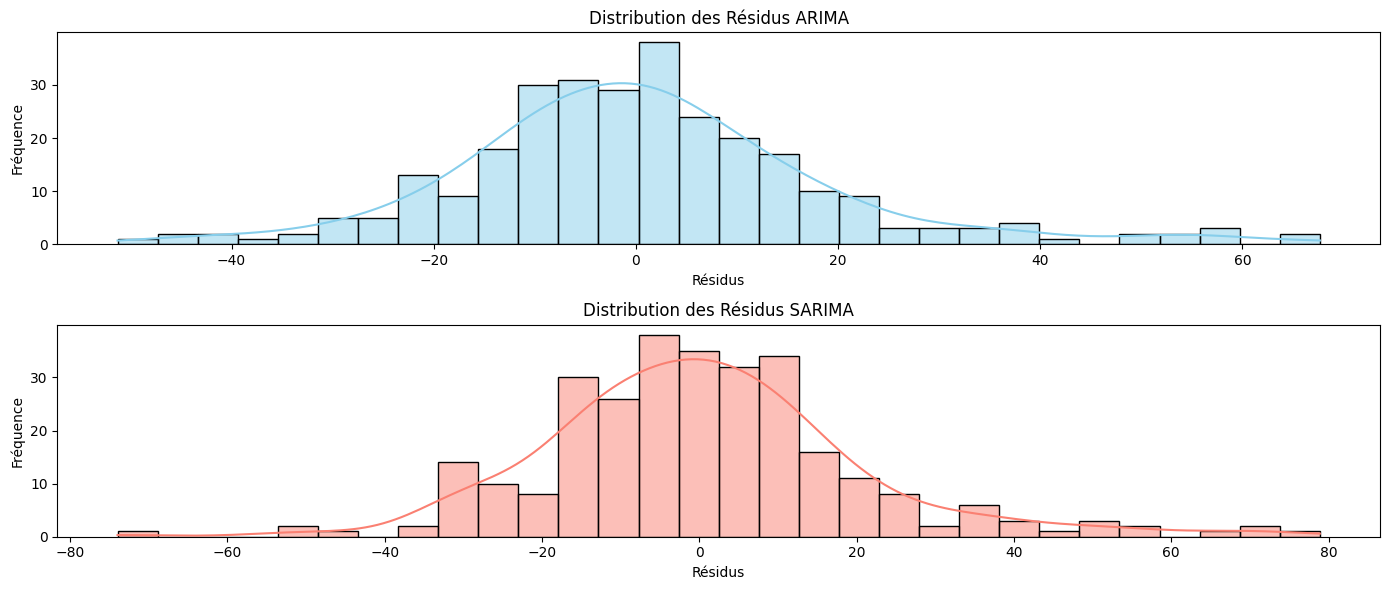

In [ ]:
# Analyse des résidus
arima_resid = arima_fit.resid
sarima_resid = sarima_fit.resid

# Config des graphiques
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
sns.histplot(arima_resid, kde=True, bins=30, color='skyblue')
plt.title('Distribution des Résidus ARIMA')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')

plt.subplot(2, 1, 2)
sns.histplot(sarima_resid, kde=True, bins=30, color='salmon')
plt.title('Distribution des Résidus SARIMA')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')


plt.tight_layout()
plt.show()


- Interprétation :
La distribution des résidus pour les modèles ARIMA et SARIMA montre que les résidus se rapprochent d'une distribution normale avec une moyenne proche de zéro. Cependant, pour ARIMA, les résidus semblent légèrement asymétriques et dispersés, ce qui pourrait indiquer une légère tendance non capturée. Les résidus SARIMA paraissent plus centrés mais avec des queues un peu étendues, ce qui suggère la présence de quelques valeurs aberrantes. Ces distributions montrent que les deux modèles capturent bien les tendances des données, mais pas parfaitement.

#9. Résultats finals

In [ ]:
# Modèle ARIMA avec les meilleurs hyperparamètres trouvés
model_arima = ARIMA(sunspot['sunspot'], order=(5, 1, 2))

# Ajustement du modèle ARIMA aux données
arima_fit = model_arima.fit()

# Affichage du modèle ARIMA ajusté
print("\nRésumé du modèle ARIMA")
print(arima_fit.summary())

# Prédictions avec ARIMA
forecast_arima = arima_fit.get_forecast(steps=10)

# les valeurs moyennes des prédictions futures pour les 10 prochaines périodes.
arima_mean = forecast_arima.predicted_mean

# les intervalles de confiance pour ces prédictions,
arima_conf_int = forecast_arima.conf_int()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Résumé du modèle ARIMA
                               SARIMAX Results                                
Dep. Variable:                sunspot   No. Observations:                  289
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1245.390
Date:                Sat, 21 Dec 2024   AIC                           2506.781
Time:                        19:46:15   BIC                           2536.084
Sample:                    01-01-1700   HQIC                          2518.524
                         - 01-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5597      0.132     11.821      0.000       1.301       1.818
ar.L2         -1.0322      0.149     -6.944      0.000      -1.324      -0.741
ar.L3          0.1141      0

- Interprétation :

In [ ]:
# Modèle SARIMA avec les meilleurs hyperparamètres trouvés
model_sarima = SARIMAX(sunspot['sunspot'], order=(4, 1, 0), seasonal_order=(1, 0, [1, 2], 11))

sarima_fit = model_sarima.fit()

print("\nRésumé du modèle SARIMA")
print(sarima_fit.summary())

forecast_sarima = sarima_fit.get_forecast(steps=10)

sarima_mean = forecast_sarima.predicted_mean

sarima_conf_int



Résumé du modèle SARIMA
                                        SARIMAX Results                                        
Dep. Variable:                                 sunspot   No. Observations:                  289
Model:             SARIMAX(4, 1, 0)x(1, 0, [1, 2], 11)   Log Likelihood               -1274.070
Date:                                 Sat, 21 Dec 2024   AIC                           2564.140
Time:                                         19:46:25   BIC                           2593.443
Sample:                                     01-01-1700   HQIC                          2575.883
                                          - 01-01-1988                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2308      0.050      4.629      

- Interprétation :
Le modèle ARIMA ajusté avec les meilleurs hyperparamètres indique un ajustement relativement solide. Les coefficients des paramètres AR et MA sont significatifs, sauf pour certains termes plus élevés. L'AIC de 2506.781 montre une amélioration par rapport à d'autres modèles testés précédemment. Le test de Jarque-Bera suggère une distribution légèrement non normale des résidus, mais la faible hétéroscédasticité indique une variabilité des erreurs relativement stable. Ce modèle semble adapté pour effectuer des prévisions à court terme, mais une évaluation de ses performances sur des données de validation reste essentielle.

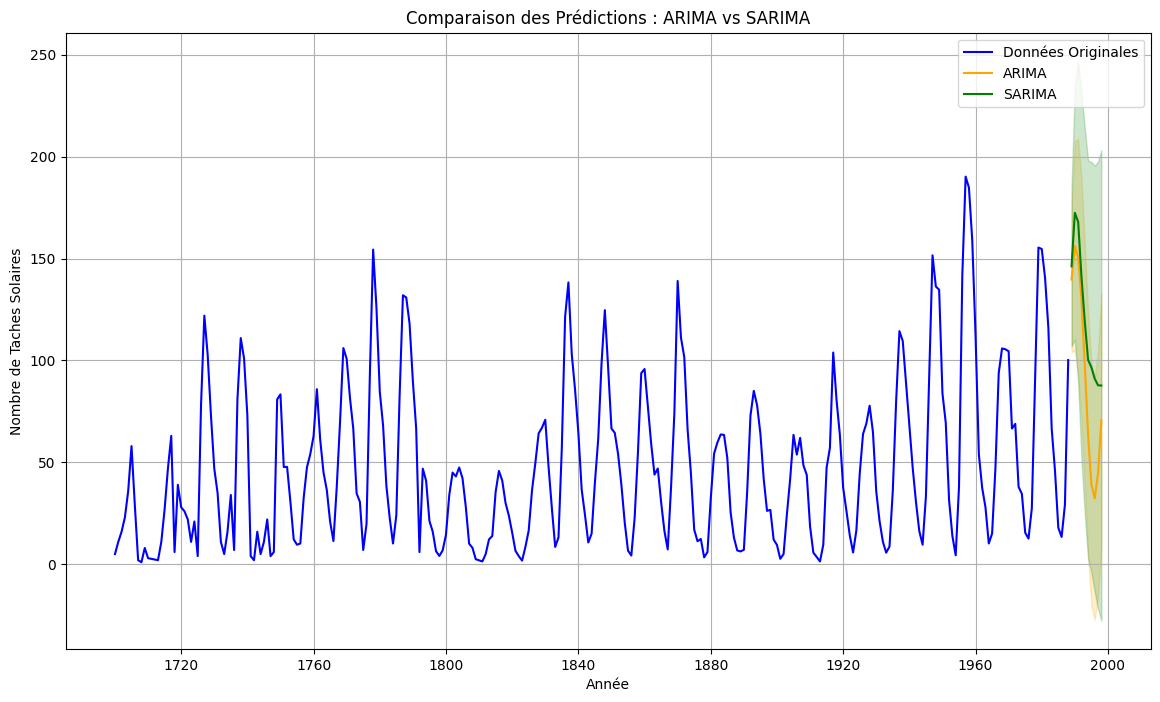

In [ ]:
# Visualisation des prédictions
plt.figure(figsize=(14, 8))
plt.plot(sunspot.index, sunspot['sunspot'], label='Données Originales', color='blue')
# Prédictions ARIMA
future_years = pd.date_range(start=sunspot.index[-1] + pd.DateOffset(years=1), periods=10, freq='YS')
plt.plot(future_years, arima_mean, label='ARIMA', color='orange')
plt.fill_between(future_years, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.2)
# Prédictions SARIMA
plt.plot(future_years, sarima_mean, label='SARIMA', color='green')
plt.fill_between(future_years, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.2)


# Configuration du graphique
plt.title('Comparaison des Prédictions : ARIMA vs SARIMA')
plt.xlabel('Année')
plt.ylabel('Nombre de Taches Solaires')
plt.legend()
plt.grid()
plt.show()

- Interprétation :
Cette visualisation compare les prédictions des modèles ARIMA et SARIMA avec les données originales. Les courbes prédictives montrent que les deux modèles capturent les tendances générales, mais leurs incertitudes diffèrent légèrement. Les intervalles de confiance mettent en évidence une incertitude accrue pour les prédictions futures, ce qui est attendu pour des prévisions à long terme. Le modèle SARIMA semble mieux refléter les variations saisonnières, tandis que l'ARIMA fournit des prédictions plus linéaires. Ces différences peuvent être importantes selon l'objectif des prévisions.

# 10. Conclusion

Ce projet a exploré la modélisation des taches solaires en utilisant des approches ARIMA et SARIMA. Les analyses montrent que les deux modèles capturent efficacement les tendances globales et les variations cycliques des données. Le modèle SARIMA, en intégrant une composante saisonnière, reflète mieux les schémas périodiques, tandis que l'ARIMA se concentre davantage sur les tendances globales. Les prédictions démontrent des performances comparables, avec un léger avantage pour l'ARIMA en termes de métriques comme l'AIC. Cependant, SARIMA offre une meilleure capture des fluctuations saisonnières. Ces résultats soulignent l'importance de choisir le modèle en fonction du contexte et des objectifs spécifiques de la prévision.

# 11. Resources :
 - Les cours de M.Anis Fradi (CMs, TDs, TP)
 - https://fr.wikipedia.org/wiki/Arima
 - https://www.quebec.ca/immigration/services-en-ligne
 - https://openclassrooms.com/fr/courses/4525371-analysez-et-modelisez-des-series-temporelles/5001226-les-processus-non-stationnaires-arima-et-sarima
 - https://www.youtube.com/watch?v=_Tc2IDEzbDE
 - https://chat.openai.com/